Testing a simple version of speckle simulator with simple charge charing included.

In [1]:
from ast import literal_eval as make_tuple
from scipy import ndimage
import numpy as np
from skimage.transform import rescale, resize, downscale_local_mean

"""
when photons are absorbed in silicon sensors and turns into electrons, there is a conversion rate.
Every 3.6 eV turns into 1 electron. For example, 360 eV photon will turn into 100 electrons and 7.2 keV
photon will turn into about 2000 electrons. The process of course is not fully deterministic and there
are many other sources of uncertainties and electron/charge loss mechanisms.
"""

def makeSpeckle(size, speckleSize = 50): # 30 will lead to a factof of 3 over sampling, thus better maintain the contrast
    image = np.zeros(size)
    xPhasors = int(np.round(size[0]/speckleSize))
    yPhasors = int(np.round(size[1]/speckleSize))
    rndPhasor = np.zeros(size)
    rndPhasor[0:xPhasors,0:yPhasors] = np.exp(np.random.random([xPhasors,yPhasors])*2.j*np.pi)
    speckleField = np.fft.fft2(rndPhasor)
    speckleIntensity = np.abs(speckleField)**2
    return speckleIntensity/np.mean(speckleIntensity.flatten())


def AddShotNoise(speckle, kbar):
    """
    generate speckle pattern as discrete photons by introducing shot noise.
    variable kbar is the average photon density over the field of view.
    """
    speckle = speckle/np.mean(speckle.flatten())*kbar;
    return np.random.poisson(speckle)

def ApplyChargeCloud(photonPattern, cloudSize, photonEnergy):
    """
    this step blurs the photon map by the charge cloud size, assuming
    every electron in silicon takes 3.6 eV to generate.
    """
    return ndimage.filters.gaussian_filter(photonPattern*photonEnergy/3.6, cloudSize/2.35, mode='wrap', truncate=7)

def rebin(a, shape):
    """
    pattern rebinning down to smaller sizes
    by adding MXN blocks together. IDL type, pretty quick.
    """
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).sum(-1).sum(1)
            

def digitizeCharge(chargePattern, chargePerADU=15, gainMap=None):
    """
    digitize the charge pattern to ADUs, with gain variation
    """
    if gainMap is None:
        gainMap = np.random.randn(chargePattern.shape[0], chargePattern.shape[1])*0.05+1;
    return chargePattern/chargePerADU # Should it bet [a*b for a,b in zip(chargePattern/chargePerADU,gainMap)]

    
def AddReadoutNoise(chargePattern, pixelReadoutNoise):
    """
    add readout noise to the detector.
    """
    return chargePattern + np.random.randn(chargePattern.shape[0], chargePattern.shape[1])*pixelReadoutNoise


In [2]:
gainMap = np.random.randn(100,100)*0.05+1;
import matplotlib.pyplot as plt
plt.figure()
plt.hist(gainMap.flatten())
plt.show()

<Figure size 640x480 with 1 Axes>

/Users/jordiarnau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


0.8094918727874756
147
146.99999999991607
147.0
146.99999999999994
148.2863814039238


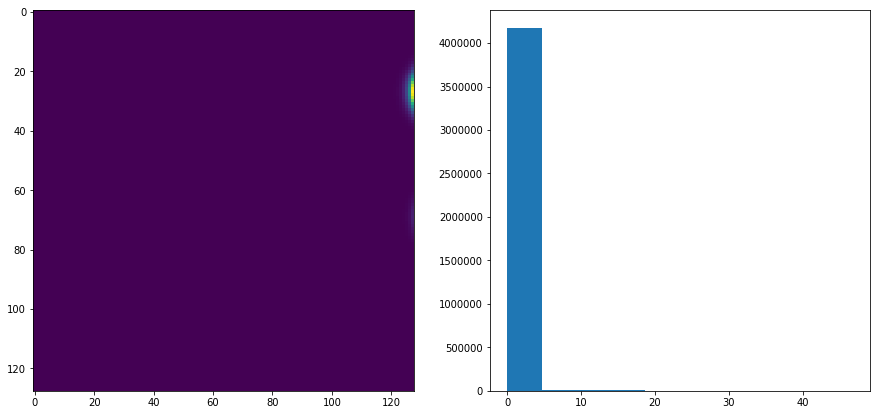

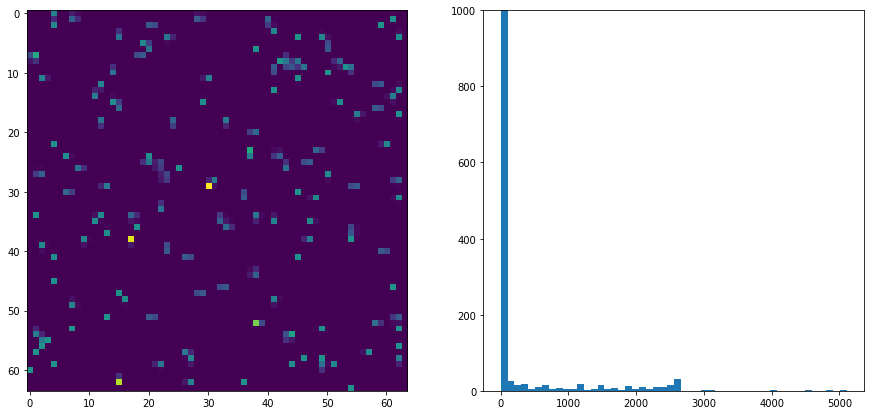

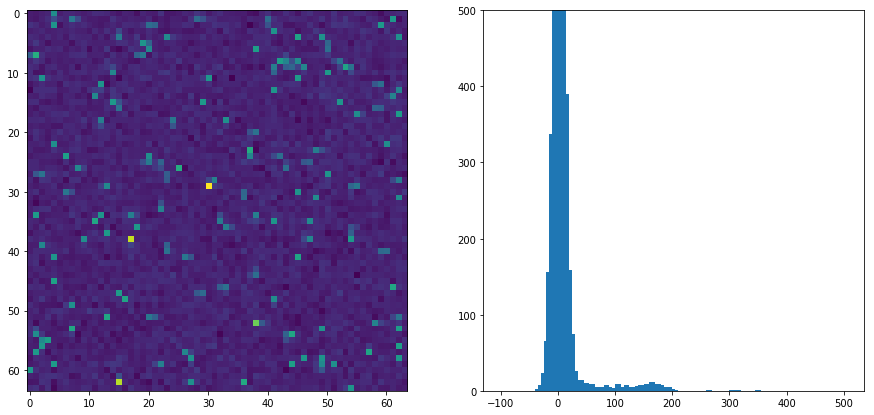

In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt

gridSize = [2048,2048]
detectorSize = [64,64]
kbar = 0.04
speckleSize = 50
chargeCloudSize = 0.3
photonEnergy = 9500
readoutNoise = 10
gainVariation = 0.05
gainMap = 1+gainVariation*np.random.randn(detectorSize[0], detectorSize[1])

kbar_grid = kbar/gridSize[0]/gridSize[1]*detectorSize[0]*detectorSize[1]
chargeCloudSize_grid = chargeCloudSize*gridSize[0]/detectorSize[0] # Should it be charge CloudSize/gridSize[0]*detectorSize[0] ?

tic = time.time()
speckle = makeSpeckle(gridSize, speckleSize)
speckleN = AddShotNoise(speckle, kbar_grid)
speckleNE = ApplyChargeCloud(speckleN, chargeCloudSize_grid, photonEnergy)
speckleD = rebin(speckleNE, detectorSize)
#speckleD = rebin_slow(speckleNE, 8)
speckleDD = digitizeCharge(speckleD, gainMap = gainMap)
speckleDN = AddReadoutNoise(speckleDD, readoutNoise)
toc = time.time();print(toc-tic)

print(sum(speckleN.flatten()))
print(sum(speckleNE.flatten())/photonEnergy*3.6)
print(sum(speckleD.flatten())/photonEnergy*3.6)
print(sum(speckleDD.flatten())/photonEnergy*3.6*15)
print(sum(speckleDN.flatten())/photonEnergy*3.6*15)

if False:
    plt.figure(figsize=[15,7]);plt.clf();
    plt.subplot(1,2,1);
    plt.imshow(speckle)
    plt.subplot(1,2,2);
    plt.hist(speckle.flatten())

    # charge distribution
plt.figure(figsize=[15,7]);plt.clf();
plt.subplot(1,2,1);
plt.imshow(speckleNE[0:128,0:128])
plt.subplot(1,2,2);
plt.hist(speckleNE.flatten())

# pixel charge distribution
plt.figure(figsize=[15,7]);plt.clf();
plt.subplot(1,2,1);
plt.imshow(speckleD)
plt.subplot(1,2,2);
plt.hist(speckleD.flatten(), 50)
plt.ylim(0,1000)

# final pattern
plt.figure(figsize=[15,7]);plt.clf();
plt.subplot(1,2,1);
plt.imshow(speckleDN)
plt.subplot(1,2,2);
binWidth = 5;
bins = np.arange(-100, 500.1, binWidth)
histFinal = np.histogram(speckleDN.flatten(), bins)
plt.bar(bins[1:], histFinal[0], width=10)
plt.ylim(0,500)
plt.show()
    



In [4]:
def makeWeakSpeckle(speckle, kbar = 0.1, speckleSize = 50, gridSize=[1024,1024], detectorSize=[128,128], 
                    chargeCloudSize=2, photonEnergy=9500, readoutNoise=10):
    """
    use the functions in the earlier section to produce a single detector image of
    a weak speckle pattern with average signal rate of kbar.
    """
    kbar_grid = kbar/gridSize[0]/gridSize[1]*detectorSize[0]*detectorSize[1]
    chargeCloudSize_grid = chargeCloudSize*gridSize[0]/detectorSize[0]
    #speckle = makeSpeckle([1024,1024],50)
    #print(chargeCloudSize_grid)
    speckleN = AddShotNoise(speckle, kbar_grid)
    speckleNE = ApplyChargeCloud(speckleN, chargeCloudSize_grid, photonEnergy)
    speckleD = rebin(speckleNE, detectorSize)
    speckleDD = digitizeCharge(speckleD)
    return AddReadoutNoise(speckleDD, readoutNoise)

def makeFlatPoisson(kbar, gridSize=[1024,1024], detectorSize =[128,128], chargeCloudSize=2.0, photonEnergy=9500.0,
                    readoutNoise=10.0):
    
    chargeCloudSize_grid = chargeCloudSize*gridSize[0]/detectorSize[0]
    kbar_grid = kbar/gridSize[0]/gridSize[1]*detectorSize[0]*detectorSize[1]
    pattern = np.ones(gridSize)
    patternN = AddShotNoise(pattern, kbar_grid)
    patternNE = ApplyChargeCloud(patternN, chargeCloudSize_grid, photonEnergy)
    patternD = rebin(patternNE, detectorSize)
    patternDD = digitizeCharge(patternD)
    return AddReadoutNoise(patternDD, readoutNoise)

In [5]:
a = np.random.poisson(np.ones([4,4])*0.2)
b = ApplyChargeCloud(a, 1, 1)
print(sum(a.flatten()))
print(sum(b.flatten())*3.6)

4
4.0


In [6]:
binWidth = 10;
bins = np.arange(-100, 1000.1, binWidth)
histFinal = np.zeros([np.shape(bins)[0]-1, 3])
nPhoton = 0
kbar = 0.1
ccs=0.5
rn=3

N = 30
for k in range(3):
    for i in range(N):
        if np.mod(i,10) == 0:
            print(i)
        speckle = makeWeakSpeckle(speckle = makeSpeckle([1024,1024],50), kbar = kbar, chargeCloudSize=ccs, readoutNoise=rn, detectorSize = [32,32])
        #speckle = makeFlatPoisson(kbar, chargeCloudSize=ccs, readoutNoise=rn, detectorSize=[32,32])
        nPhoton += (sum(speckle.flatten())/9500*3.6*15);
        histHere = np.histogram(speckle.flatten(), bins)
        histFinal[:,k] +=histHere[0]
print('DONE\n');
print('total number of photons: %d\n' % nPhoton)
print('simulated kbar: %.6f\n' % (nPhoton/128/128/N))

0


/Users/jordiarnau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
0
10
20
0
10
20
DONE

total number of photons: 9212

simulated kbar: 0.018743



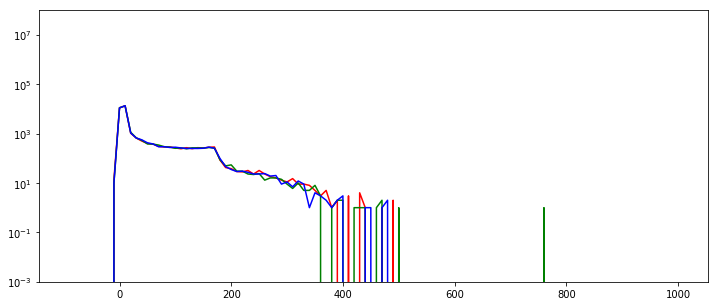

In [7]:
# take a look at the sum histogram, trying to make it similar to a real detector
# ... still some artifact from 32x32 spatial sampling of a pixel

plt.figure(figsize=[12,5]);plt.clf();
plt.semilogy(bins[1:], histFinal[:,0], 'r')
plt.semilogy(bins[1:], histFinal[:,1], 'g')
plt.semilogy(bins[1:], histFinal[:,2], 'b')
plt.ylim(1e-3,1e8)
plt.show()

We now have raw histogram.
Need to make the histogram after droplet be like what we expect in the paper.
Run droplet on the simulated dataset and see if it matches with the original photons and see if there are some kind of droplets that tend to mislead the algorithm. 
The ratio between 1, 2, 3-photon events gives us the contrast. Compare that to the original. And compare the different droplet algorithms, see which one is better, gives better contrast. Play with different kbars, 0.1,0.01, smaller.

0


/Users/jordiarnau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


10
0
10
0
10
DONE

total number of photons: 5915

simulated kbar: 0.018054



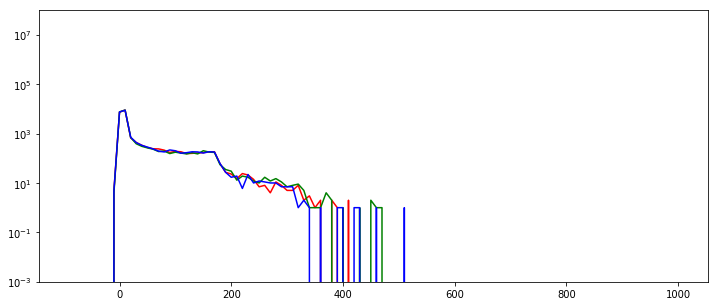

In [8]:
binWidth = 10;
bins = np.arange(-100, 1000.1, binWidth)
histFinal = np.zeros([np.shape(bins)[0]-1, 3])
nPhoton = 0
kbar = 0.1
ccs=0.5
rn=3

N = 20
for k in range(3):
    for i in range(N):
        if np.mod(i,10) == 0:
            print(i)
        speckle = makeWeakSpeckle(speckle = makeSpeckle([1024,1024],50), kbar = kbar, chargeCloudSize=ccs, readoutNoise=rn, detectorSize=[32,32])
        #speckle = makeFlatPoisson(kbar, chargeCloudSize=ccs, readoutNoise=rn, detectorSize=[32,32])
        nPhoton += (sum(speckle.flatten())/9500*3.6*15);
        histHere = np.histogram(speckle.flatten(), bins)
        histFinal[:,k] += histHere[0]
print('DONE\n');
print('total number of photons: %d\n' % nPhoton)
print('simulated kbar: %.6f\n' % (nPhoton/128/128/N))

# take a look at the sum histogram, trying to make it similar to a real detector
# ... still some artifact from 32x32 spatial sampling of a pixel

plt.figure(figsize=[12,5]);plt.clf();
plt.semilogy(bins[1:], histFinal[:,0], 'r')
plt.semilogy(bins[1:], histFinal[:,1], 'g')
plt.semilogy(bins[1:], histFinal[:,2], 'b')
plt.ylim(1e-3,1e8)
plt.show()

In [ ]:
import multiprocessing as mp
from numba import prange
from time import time

def PhotonHistBatch(N):
    """generate a histogram from N images"""
    tic = time()
    binWidth = 10;
    bins = np.arange(-100, 1000.1, binWidth)
    histFinal = np.zeros([np.shape(bins)[0]-1])
    gridSize = [2**10,2**10]
    speckleSize = 50
    fixedSpeckle = makeSpeckle(size = gridSize,speckleSize = speckleSize)
    
    np.random.seed() # Otherwise each thread gets the same pseudorandom number and you get the same plot 4 times

    for i in prange(N):
        if np.mod(i,10) == 0:
            print(i)
        speckle = makeWeakSpeckle(speckle = fixedSpeckle, kbar=0.1, speckleSize=speckleSize, gridSize=gridSize, 
                                  detectorSize=[32,32], chargeCloudSize=0.5,photonEnergy=9500, readoutNoise=3)
        histHere = np.histogram(speckle.flatten(), bins)
        histFinal += histHere[0]
    toc = time()
    print(toc-tic)
    return histFinal

# Note: after using threading multiple times, there is usually an error that says
# that there are too many instances open. Restart kernel and reset output to continue.
def threading():
    pool = mp.Pool(3)
    N = 10000
    result = pool.map(PhotonHistBatch, [N,N,N])
    return result

In [ ]:
result = threading()

/Users/jordiarnau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/jordiarnau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/jordiarnau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


0
0
0
10
10
10
20
20
20
30
30
30
40
40
40
50
50
50
60
60
60
70
70
70
80
80
80
90
90
90
100
100
100
110
110
110
120
120
120
130
130
130
140
140
140
150
150
150
160
160
160
170
170
170
180
180
180
190
190
190
200
200
200
210
210
210
220
220
220
230
230
230
240
240
240
250
250
250
260
260
260
270
270
270
280
280
280
290
290
290
300
300
300
310
310
310
320
320
320
330
330
330
340
340
340
350
350
350
360
360
360
370
370
370
380
380
380
390
390
390
400
400
400
410
410
410
420
420
420
430
430
430
440
440
440
450
450
450
460
460
460
470
470
470
480
480
480
490
490
490
500
500
500
510
510
510
520
520
520
530
530
530
540
540
540
550
550
550
560
560
560
570
570
570
580
580
580
590
590
590
600
600
600
610
610
610
620
620
620
630
630
630
640
640
640
650
650
650
660
660
660
670
670
670
680
680
680
690
690
690
700
700
700
710
710
710
720
720
720
730
730
730
740
740
740
750
750
750
760
760
760
770
770
770
780
780
780
790
790
790
800
800
800
810
810
810
820
820
820
830
830
830
840
840
840
850
850
850
8

In [ ]:
binWidth = 10;
bins = np.arange(-100, 1000.1, binWidth)

plt.figure(figsize=[12,5]);plt.clf();
plt.semilogy(bins[1:], result[0], 'r')
plt.semilogy(bins[1:], result[1], 'g')
plt.semilogy(bins[1:], result[2], 'b')
#plt.semilogy(bins[1:], result[3], 'c')
plt.title("Detector size 32, kbar = 0.1, N = 10000")
plt.ylim(1e-3,1e7)
plt.show()

In [ ]:
import h5py
h = h5py.File('d32kbar0-1N10000.hdf5','w')
h.create_dataset("thread1", data = result[0])
h.create_dataset("thread2", data = result[1])
h.create_dataset("thread3", data = result[2])
h.create_dataset("bins", data = bins)
h.close()

In [ ]:
binWidth = 10;
bins = np.arange(-100, 1000.1, binWidth)

plt.figure(figsize=[12,5]);plt.clf();
plt.semilogy(bins[1:], result[0], 'r')
plt.semilogy(bins[1:], result[1], 'g')
plt.semilogy(bins[1:], result[2], 'b')
plt.semilogy(bins[1:], result[3], 'c')
plt.ylim(1e-3,1e8)
plt.show()

In [ ]:
import multiprocessing as mp
mp.cpu_count()

In [ ]:
def my_func(x):
  print(x**x)
  return x**x

def main():
  pool = mp.Pool(mp.cpu_count())
  result = pool.map(my_func, [4,2,3])
  print result

if __name__ == "__main__":
  main()

In [ ]:
n = np.ones([8,8])
nr = rebin(n,[2,2])
print n
print nr

In [ ]:
"""test generating poission probabilities ... seems good for small k expectation values,
and some numerical divergence when go to bigger values than 20.
if we use np.random.choice, we need to provide the poission probability distribution, or we can use the build in
poission random function."""

import numpy as np
from scipy.special import factorial
from matplotlib import pyplot as plot
k = np.arange(20)
k_expectation = 0.1
poisson_dist = np.exp(-k_expectation)*(k_expectation**k)/factorial(k);

plt.figure(figsize = [15,5]);plt.clf;
plt.subplot(1,2,1)
plt.plot(poisson_dist, '--ok')
plt.subplot(1,2,2)
plt.semilogy(poisson_dist, '--ok')
plt.show()

# now use the built in function
a = np.mgrid[0:3:0.2,0:3:0.2]
print a[0]
ar = np.random.poisson(a[0]*0.1)

plt.figure();
plt.imshow(ar)
plt.show()
print ar